In [1]:
# Import all the packages that will be used
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import datetime


#Load data sets
report = pd.read_csv('./report.csv')
birth = pd.read_csv('./birth.csv')
breed = pd.read_csv('./breed.csv')
spec = pd.read_csv('./spec.csv')


#Rename columns
report.columns = ['ID','Year','Month','FarmCode','CowNo','FatherSemenNo','MotherNo','BirthDate','Parity',
                  'DaysOfLactation','MilkYield','LatestCalvingDate','SampleDate','AgeInMonths','TestingDate',
                  'LastBreedingDate','LastBreedingSemen','NumberOfBreeding','PreviousCalvingDate',
                  'FirstBreedingDate','FirstBreedingSemen']
birth.columns = ['CowNo','CalvingDate','DryDate','CalfNo1','CalfNo2','MotherWeight','RecordingDate',
                 'IfParityRecorded','Parity','HardnessOfCalving','CalfSize','CalfGender','FarmCode']
breed.columns = ['CowNo','BreedingDate','BreedingSemen','RecordingDate','PregnancyTest','BreedingMethod',
                 'SemenType','FarmCode']
spec.columns = ['CowNo','SituationType','SituationCode','SituationDate','Remarks','RecordingDate','FarmCode']

/Users/guanguan/opt/anaconda3/envs/tf/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
report.head()

,ID,Year,Month,FarmCode,CowNo,FatherSemenNo,MotherNo,BirthDate,Parity,DaysOfLactation,...,LatestCalvingDate,SampleDate,AgeInMonths,TestingDate,LastBreedingDate,LastBreedingSemen,NumberOfBreeding,PreviousCalvingDate,FirstBreedingDate,FirstBreedingSemen
0,1,2013,3,A,52612,507H7173,96040545,2011/1/1 00:00,1,78.0,...,2013/1/1 00:00,2013/3/20 00:00,26,2013/3/21 00:00,2015/5/5 00:00,507H11621,1,NaN,2013/3/5 00:00,501H8784
1,2,2013,4,A,52612,507H7173,96040545,2011/1/1 00:00,1,107.0,...,2013/1/1 00:00,2013/4/18 00:00,27,2013/4/19 00:00,2015/5/5 00:00,507H11621,1,NaN,2013/3/5 00:00,501H8784
2,3,2013,5,A,52612,507H7173,96040545,2011/1/1 00:00,1,140.0,...,2013/1/1 00:00,2013/5/21 00:00,28,2013/5/22 00:00,2015/5/5 00:00,507H11621,2,NaN,2013/3/5 00:00,501H8784
3,4,2013,6,A,52612,507H7173,96040545,2011/1/1 00:00,1,175.0,...,2013/1/1 00:00,2013/6/25 00:00,29,2013/6/26 00:00,2015/5/5 00:00,507H11621,2,NaN,2013/3/5 00:00,501H8784
4,5,2013,7,A,52612,507H7173,96040545,2011/1/1 00:00,1,210.0,...,2013/1/1 00:00,2013/7/30 00:00,30,2013/7/31 00:00,2015/5/5 00:00,507H11621,2,NaN,2013/3/5 00:00,501H8784


In [3]:
print(report['ID'].nunique())
print(report['CowNo'].nunique())
print(report['Year'].unique())
print(report['FarmCode'].unique())

37517
1991
[2013 2014 2015 2016 2017 2018 2019]
['A' 'B' 'C']


In [4]:
# Section 1: Data Cleaning

# Basic and important features: 'Year', 'Month', 'FarmCode', 'Parity', 'DaysOfLactation', 'AgeInMonths', 'MilkYield'
# Drop the rows missing any of these values
# Drop the rows with 0 milk yield

cleaning_report = report.copy()
cols = ['Year', 'Month', 'FarmCode', 'Parity', 'DaysOfLactation', 'AgeInMonths', 'MilkYield']
cleaning_report = cleaning_report.dropna(subset=cols)
filt = (cleaning_report['MilkYield'] == 0)
cleaning_report = cleaning_report.drop(cleaning_report[filt].index)

In [5]:
print(cleaning_report['ID'].nunique())
print(cleaning_report['CowNo'].nunique())
print(cleaning_report['Year'].unique())
print(cleaning_report['FarmCode'].unique())

33185
1818
[2013 2014 2015 2016 2017 2018]
['A' 'B' 'C']


In [6]:
# "The targert of this project: Using the data from 2013 ~ 2017 to predict the milk yield in 2018"
# To mimic predicting milk yield in the next year with all past data by this year

# Check if there is new information in 2018.
data2013_2017 = cleaning_report[cleaning_report['Year'] != 2018]
data_2018 = cleaning_report[cleaning_report['Year'] == 2018]

target_cols = ['ID','FarmCode','CowNo','FatherSemenNo','MotherNo','Parity','DaysOfLactation','AgeInMonths',
               'LastBreedingSemen','NumberOfBreeding','FirstBreedingSemen']
for x in target_cols:
    filter = ~(data_2018[x].isin(list(data2013_2017[x])))
    newinfo = data_2018[filter]
    print(x+':')
    if len(newinfo)==0:
        print('There is no new information in 2018.\n')
    else:
        print('The number of rows in 2018 with new value: {}'.format(len(newinfo[x])))
        print('The number of new values in 2018: {}\n'.format(newinfo[x].nunique()))

        
# New cows, mother cows, father semen, and breeding semen appear in 2018.

ID:
The number of rows in 2018 with new value: 7155
The number of new values in 2018: 7155

FarmCode:
There is no new information in 2018.

CowNo:
The number of rows in 2018 with new value: 2034
The number of new values in 2018: 304

FatherSemenNo:
The number of rows in 2018 with new value: 948
The number of new values in 2018: 33

MotherNo:
The number of rows in 2018 with new value: 1188
The number of new values in 2018: 139

Parity:
There is no new information in 2018.

DaysOfLactation:
The number of rows in 2018 with new value: 11
The number of new values in 2018: 11

AgeInMonths:
There is no new information in 2018.

LastBreedingSemen:
The number of rows in 2018 with new value: 253
The number of new values in 2018: 17

NumberOfBreeding:
There is no new information in 2018.

FirstBreedingSemen:
The number of rows in 2018 with new value: 1379
The number of new values in 2018: 25



In [7]:
# Define a function for evaluating the model (to show correlation coefficient, RMSE, and accuracy)
def evaluate(model, test_features, test_labels):
    preds = model.predict(test_features)
    rmse = sqrt(mean_squared_error(test_labels, preds))
    errors = abs(preds - test_labels)
    mape = 100 * np.nanmean(errors / test_labels)
    accuracy = 100 - mape
    preds_df = pd.DataFrame({'Actual_values':test_labels, 
                             'Prediction_values':preds})
    corr_df = preds_df.corr(method='pearson')
    corr = corr_df.loc['Actual_values','Prediction_values']
    print('Correlation Coefficient = {:0.4f}'.format(corr))
    print('RMSE = {:0.4f}'.format(rmse))
    print('Accuracy= {:0.2f}%'.format(accuracy))
    return accuracy

In [8]:
# Feature combination 1 (F1): Basic features
# Features: 'Month', 'FarmCode', 'Parity', 'DaysOfLactation', 'AgeInMonths', 'MilkYield'

# Divide the training data set into 3 part, train and test (8:2), and data in 2018
# Train for training the model and test to check the accuracy of the model
# Data in 2018 will be used to evaluate the final performance of the models

cols = ['Month', 'FarmCode', 'Parity', 'DaysOfLactation', 'AgeInMonths', 'MilkYield']
df1 = cleaning_report[cleaning_report['Year'] != 2018]
df1 = pd.get_dummies(df1[cols]).copy()
X = df1.drop(['MilkYield'], axis=1)
y = df1['MilkYield']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
print(X_train.shape)

(20824, 7)


Model Performance

SVR:
Correlation Coefficient = 0.7013
RMSE = 6.2965
Accuracy= 74.86%

Random Forest:
Correlation Coefficient = 0.6746
RMSE = 6.5527
Accuracy= 74.47%

XGBoost:
Correlation Coefficient = 0.7071
RMSE = 6.2324
Accuracy= 75.35%


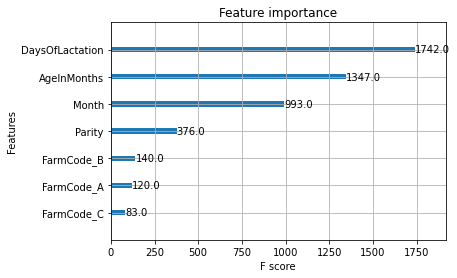

In [9]:
# Try different algorithms

print('Model Performance')

# 1. SVR
sc = StandardScaler()
scaledX_train = sc.fit_transform(X_train)
scaledX_train = pd.DataFrame(data = scaledX_train, columns = X_train.columns)
scaledX_test = sc.fit_transform(X_test)
scaledX_test = pd.DataFrame(data = scaledX_test, columns = X_test.columns)
m1_svr = SVR()
m1_svr.fit(scaledX_train, y_train)
print('\nSVR:')
m1_svr_acc = evaluate(m1_svr, scaledX_test, y_test)

# 2. Random Forest
m1_rf = RandomForestRegressor(random_state=42)
m1_rf.fit(X_train, y_train)
print('\nRandom Forest:')
m1_rf_acc = evaluate(m1_rf, X_test, y_test)

# 3. XGBoost
m1_xgb = XGBRegressor(seed=42)
m1_xgb.fit(X_train, y_train)
print('\nXGBoost:')
m1_xgb_acc = evaluate(m1_xgb, X_test, y_test)
plot_importance(m1_xgb)
plt.show()

In [10]:
# Section 2: Feature Generation (from report data set)

# Create new columns of seasons
spring = [3, 4, 5]
summer = [6, 7, 8]
autumn = [9, 10, 11]
winter = [12, 1, 2]

# 1. 'MilkingSeason'
cleaning_report['MilkingSeason'] = ''
for i in cleaning_report.index:
    month = cleaning_report.loc[i, 'Month']
    if month in spring:
        cleaning_report.loc[i, 'MilkingSeason'] = 'Spring'
    if month in summer:
        cleaning_report.loc[i, 'MilkingSeason'] = 'Summer'
    if month in autumn:
        cleaning_report.loc[i, 'MilkingSeason'] = 'Autumn'
    if month in winter:
        cleaning_report.loc[i, 'MilkingSeason'] = 'Winter'

#  2. 'BirthSeason'
cleaning_report['BirthSeason'] = ''
for i in cleaning_report.index:
    month = int(cleaning_report.loc[i, 'BirthDate'][5])
    if month in spring:
        cleaning_report.loc[i, 'BirthSeason'] = 'Spring'
    elif month in summer:
        cleaning_report.loc[i, 'BirthSeason'] = 'Summer'
    elif month in autumn:
        cleaning_report.loc[i, 'BirthSeason'] = 'Autumn'
    elif month in winter:
        cleaning_report.loc[i, 'BirthSeason'] = 'Winter'

#  3. 'CalvingSeason'
cleaning_report['CalvingSeason'] = ''
for i in cleaning_report.index:
    month = int(cleaning_report.loc[i, 'LatestCalvingDate'][5])
    if month in spring:
        cleaning_report.loc[i, 'CalvingSeason'] = 'Spring'
    elif month in summer:
        cleaning_report.loc[i, 'CalvingSeason'] = 'Summer'
    elif month in autumn:
        cleaning_report.loc[i, 'CalvingSeason'] = 'Autumn'
    elif month in winter:
        cleaning_report.loc[i, 'CalvingSeason'] = 'Winter'

        
# Create new columns: 'CalvingInterval' & 'IfFirstCalving'
cleaning_report['BirthDate'] = pd.to_datetime(cleaning_report['BirthDate'])
cleaning_report['SampleDate'] = pd.to_datetime(cleaning_report['SampleDate'])
cleaning_report['LatestCalvingDate'] = pd.to_datetime(cleaning_report['LatestCalvingDate'])
cleaning_report['PreviousCalvingDate'] = pd.to_datetime(cleaning_report['PreviousCalvingDate'])
cleaning_report['CalvingInterval'] = (cleaning_report['LatestCalvingDate'] - cleaning_report['PreviousCalvingDate']).astype('timedelta64[D]')
cleaning_report['IfFirstCalving'] = np.nan
for i in cleaning_report.index:
    if cleaning_report.loc[i, 'Parity'] == 1:
        cleaning_report.loc[i, 'CalvingInterval']= int(0)
        cleaning_report.loc[i, 'IfFirstCalving']= int(0)
    else:
        cleaning_report.loc[i, 'IfFirstCalving']= int(1)   

# Create a new column: 'AverageYield'
# Using the average yield of each cow (from 2013 to the previous year) to represent the productivity
# For the year 2013, there would be no information
cleaning_report['AverageYield'] = np.nan
for x in list(cleaning_report['CowNo'].unique()):
    filt = (cleaning_report['CowNo']==x)
    df_cow = cleaning_report[filt]
    for year in list(df_cow['Year'].unique()):
        filt = (df_cow['Year']<year)
        past_df_cow = df_cow[filt]
        yieldlist = [x for x in past_df_cow['MilkYield'] if x != 0 and pd.isnull(x)==False]
        if len(yieldlist) != 0:
            aver = sum(yieldlist)/len(yieldlist)
            for i in df_cow[df_cow['Year']==year].index:
                cleaning_report.loc[i,'AverageYield'] = aver

print(cleaning_report.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33185 entries, 0 to 37516
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   33185 non-null  int64         
 1   Year                 33185 non-null  int64         
 2   Month                33185 non-null  int64         
 3   FarmCode             33185 non-null  object        
 4   CowNo                33185 non-null  int64         
 5   FatherSemenNo        32557 non-null  object        
 6   MotherNo             29940 non-null  object        
 7   BirthDate            33185 non-null  datetime64[ns]
 8   Parity               33185 non-null  int64         
 9   DaysOfLactation      33185 non-null  float64       
 10  MilkYield            33185 non-null  float64       
 11  LatestCalvingDate    33185 non-null  datetime64[ns]
 12  SampleDate           33185 non-null  datetime64[ns]
 13  AgeInMonths          33185 non-

In [11]:
# Define a function for imputation
def imputation(data):
    for col in data.columns:
        if col == 'AverageYield':
            valuelist = [x for x in data[col] if x != 0 and pd.isnull(x)==False]
            mean = sum(valuelist)/len(valuelist)
            data[col] = data[col].fillna(mean)
        else:
            data[col] = data[col].fillna(data[col].median())

# Define a funtion for testing different algorithms
def test_algorithms(X_train, X_test, y_train, y_test):
    print('X_train shape:', X_train.shape, '\n')
    print('Model Performance')
    
    sc = StandardScaler()
    scaledX_train = sc.fit_transform(X_train)
    scaledX_train = pd.DataFrame(data = scaledX_train, columns = X_train.columns)
    scaledX_test = sc.fit_transform(X_test)
    scaledX_test = pd.DataFrame(data = scaledX_test, columns = X_test.columns)
    m_svr = SVR()
    m_svr.fit(scaledX_train, y_train)
    print('\nSVR:')
    m_svr_accuracy = evaluate(m_svr, scaledX_test, y_test)

    m_rf = RandomForestRegressor(random_state=42)
    m_rf.fit(X_train, y_train)
    print('\nRF:')
    m_rf_accuracy = evaluate(m_rf, X_test, y_test)

    m_xgb = XGBRegressor(seed=42)
    m_xgb.fit(X_train, y_train)
    print('\nXGB:')
    m_xgb_accuracy = evaluate(m_xgb, X_test, y_test)
    plot_importance(m_xgb, max_num_features=20)
    plt.show()

    return m_svr_accuracy, m_rf_accuracy, m_xgb_accuracy

X_train shape: (20824, 22) 

Model Performance

SVR:
Correlation Coefficient = 0.7269
RMSE = 6.0660
Accuracy= 76.07%

RF:
Correlation Coefficient = 0.7639
RMSE = 5.6810
Accuracy= 78.53%

XGB:
Correlation Coefficient = 0.7860
RMSE = 5.4429
Accuracy= 79.46%


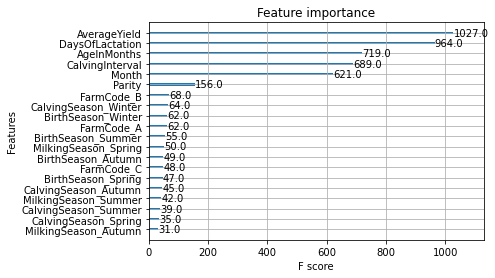

In [12]:
# Feature combination 2 (F2): F1 + columns generated from report data set
# Features: 'Month', 'FarmCode', 'Parity', 'DaysOfLactation', 'AgeInMonths', 'MilkYield''Month', 'FarmCode', 'Parity', 'DaysOfLactation', 'AgeInMonths', 'MilkYield',
#           'MilkingSeason', 'BirthSeason', 'CalvingSeason', 'CalvingInterval', 'IfFirstCalving', 'AverageYield'

cols = ['Month', 'FarmCode', 'Parity', 'DaysOfLactation', 'AgeInMonths', 'MilkYield', 'MilkingSeason',
        'BirthSeason', 'CalvingSeason', 'CalvingInterval', 'IfFirstCalving', 'AverageYield']
df2 = cleaning_report[cleaning_report['Year'] != 2018]
df2 = pd.get_dummies(df2[cols]).copy()
X = df2.drop(['MilkYield'], axis=1)
y = df2['MilkYield']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

X_train = X_train.copy()
X_test = X_test.copy()
imputation(X_train)
imputation(X_test)
    
m2_svr_acc, m2_rf_acc, m2_xgb_acc = test_algorithms(X_train, X_test, y_train, y_test)

# The model performance is better than F1.

In [13]:
# Section 3: Feature Generation (from birth data set)

# Check if a same CowNo appears in different farms for dataframe merging later
cleaning_report = cleaning_report.reset_index(drop = True)

listAB = []
listBC = []
listAC = []

setA = set(cleaning_report.CowNo[cleaning_report['FarmCode'] == 'A'])
setB = set(cleaning_report.CowNo[cleaning_report['FarmCode'] == 'B'])
setC = set(cleaning_report.CowNo[cleaning_report['FarmCode'] == 'C'])

for x in setA:
    if x in setB:
        listAB.append(x)
    if x in setC:
        listAC.append(x)
for x in setB:
    if x in setC:
        listBC.append(x)
        
print(listAB)
print(listAC)
print(listBC)

# All cows have different numbers.

[]
[]
[]


In [14]:
birth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3761 entries, 0 to 3760
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CowNo              3761 non-null   int64  
 1   CalvingDate        3761 non-null   object 
 2   DryDate            2124 non-null   object 
 3   CalfNo1            854 non-null    object 
 4   CalfNo2            8 non-null      object 
 5   MotherWeight       710 non-null    float64
 6   RecordingDate      3761 non-null   object 
 7   IfParityRecorded   3761 non-null   bool   
 8   Parity             3761 non-null   int64  
 9   HardnessOfCalving  2858 non-null   float64
 10  CalfSize           353 non-null    object 
 11  CalfGender         959 non-null    object 
 12  FarmCode           3761 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(8)
memory usage: 356.4+ KB


In [15]:
# Create 'DryPeriod'
# Dry period means the time that a cow stops producing milk.
# It will affect the following lactation.
cols = ['CowNo', 'CalvingDate','DryDate']
birth1 = birth[cols].copy()
birth1['CalvingDate'] = pd.to_datetime(birth1['CalvingDate'])
birth1['DryDate'] = pd.to_datetime(birth1['DryDate'])
birth1.rename(columns={'CalvingDate':'PreviousCalvingDate', 'DryDate':'PreviousDryDate'}, inplace=True)
cleaning_report = pd.merge(cleaning_report, birth1, on=['CowNo', 'PreviousCalvingDate'], how='left')
cleaning_report['DryPeriod'] = (cleaning_report['LatestCalvingDate'] - cleaning_report['PreviousDryDate']).astype('timedelta64[D]')
for i in cleaning_report.index:
    if pd.isnull(cleaning_report.loc[i, 'Parity']) == 1:
        cleaning_report.loc[i, 'DryPeriod']=0

# Add 'HardnessOfCalving'
cols = ['CowNo', 'CalvingDate','HardnessOfCalving']
birth1 = birth[cols].copy()
birth1['CalvingDate'] = pd.to_datetime(birth1['CalvingDate'])
birth1.rename(columns={'CalvingDate':'LatestCalvingDate'}, inplace=True)
cleaning_report = pd.merge(cleaning_report, birth1, on=['CowNo', 'LatestCalvingDate'], how='left')

In [16]:
cleaning_report.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33185 entries, 0 to 33184
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   33185 non-null  int64         
 1   Year                 33185 non-null  int64         
 2   Month                33185 non-null  int64         
 3   FarmCode             33185 non-null  object        
 4   CowNo                33185 non-null  int64         
 5   FatherSemenNo        32557 non-null  object        
 6   MotherNo             29940 non-null  object        
 7   BirthDate            33185 non-null  datetime64[ns]
 8   Parity               33185 non-null  int64         
 9   DaysOfLactation      33185 non-null  float64       
 10  MilkYield            33185 non-null  float64       
 11  LatestCalvingDate    33185 non-null  datetime64[ns]
 12  SampleDate           33185 non-null  datetime64[ns]
 13  AgeInMonths          33185 non-

X_train shape: (20824, 24) 

Model Performance

SVR:
Correlation Coefficient = 0.7251
RMSE = 6.0843
Accuracy= 75.97%

RF:
Correlation Coefficient = 0.7706
RMSE = 5.6096
Accuracy= 78.68%

XGB:
Correlation Coefficient = 0.7848
RMSE = 5.4832
Accuracy= 79.75%


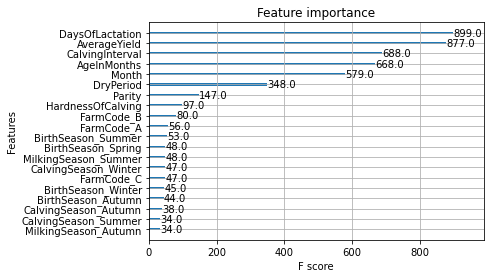

In [17]:
# Feature combination 3 (F3): F2 + columns generated from birth data set
# Features: 'Month', 'FarmCode', 'Parity', 'DaysOfLactation', 'AgeInMonths', 'MilkYield'
#           'MilkingSeason', 'BirthSeason', 'CalvingSeason', 'CalvingInterval', 'IfFirstCalving', 'AverageYield',
#           'DryPeriod', 'HardnessOfCalving'
# For 'DryPeriod', impute median when the value <= 0

cols = ['Month', 'FarmCode', 'Parity', 'DaysOfLactation', 'AgeInMonths', 'MilkYield', 'MilkingSeason',
        'BirthSeason', 'CalvingSeason', 'CalvingInterval', 'IfFirstCalving', 'AverageYield', 'DryPeriod',
        'HardnessOfCalving']
df3 = cleaning_report[cleaning_report['Year'] != 2018]
df3 = pd.get_dummies(df3[cols]).copy()
for i in df3.index:
    if df3.loc[i, 'DryPeriod'] <=0:
        df3.loc[i, 'DryPeriod'] = np.nan
X = df3.drop(['MilkYield'], axis=1)
y = df3['MilkYield']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

X_train = X_train.copy()
X_test = X_test.copy()
imputation(X_train)
imputation(X_test)

m3_svr_acc, m3_rf_acc, m3_xgb_acc = test_algorithms(X_train, X_test, y_train, y_test)

# The performance is about the same as Model 2.

In [18]:
cleaning_report.describe()

,ID,Year,Month,CowNo,Parity,DaysOfLactation,MilkYield,AgeInMonths,NumberOfBreeding,CalvingInterval,IfFirstCalving,AverageYield,DryPeriod,HardnessOfCalving
count,33185.000000,33185.000000,33185.000000,3.318500e+04,33185.000000,33185.000000,33185.000000,33185.000000,33185.000000,33135.000000,33185.000000,20914.000000,12808.000000,22840.000000
mean,18548.120386,2015.759771,6.496248,2.559435e+07,1.953021,206.175441,24.041242,47.528432,1.969504,238.306836,0.529094,25.084894,59.596268,1.257093
std,10769.775824,1.704259,3.431113,4.090803e+07,1.224102,150.031259,8.683938,19.294014,2.130174,247.268518,0.499160,5.530261,355.772754,0.459601
min,1.000000,2013.000000,1.000000,5.261200e+04,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,5.000000,-22945.000000,1.000000
25%,9427.000000,2014.000000,4.000000,1.123375e+06,1.000000,89.000000,18.000000,33.000000,0.000000,0.000000,0.000000,21.059259,54.000000,1.000000
50%,18392.000000,2016.000000,6.000000,3.125318e+06,2.000000,182.000000,23.500000,43.000000,1.000000,319.000000,1.000000,25.407407,60.000000,1.000000
75%,27838.000000,2017.000000,10.000000,1.083798e+07,2.000000,288.000000,30.000000,57.000000,3.000000,416.000000,1.000000,29.162500,66.000000,1.000000
max,37517.000000,2018.000000,12.000000,9.918321e+07,11.000000,1789.000000,61.000000,160.000000,16.000000,1234.000000,1.000000,41.000000,659.000000,5.000000


In [19]:
# Try fixing 'DryPeriod' from birth data set
df = cleaning_report.copy()
filt = (df['DryPeriod'] <= 0)
print(set(df.loc[filt, 'CowNo']))

# Define functions for fixing the date
class fix:
    def date(data, index, date):
        data.loc[index, 'CalvingDate'] = pd.to_datetime(date)
    def fir(data, cow, par2, date2, date3):
        filt = (data['CowNo'] == cow) & (data['SampleDate'] >= date2) & (data['SampleDate'] < date3)
        data.loc[filt, 'LatestCalvingDate'] = pd.to_datetime(date2)
        data.loc[filt, 'PreviousCalvingDate'] = np.nan
        data.loc[filt, 'Parity'] = int(par2)
    def mid(data, cow, par2, date1, date2, date3):
        filt = (data['CowNo'] == cow) & (data['SampleDate'] >= date2) & (data['SampleDate'] < date3)
        data.loc[filt, 'LatestCalvingDate'] = pd.to_datetime(date2)
        data.loc[filt, 'PreviousCalvingDate'] = pd.to_datetime(date1)
        data.loc[filt, 'Parity'] = int(par2)
    def last(data, cow, par2, date1, date2):
        filt = (data['CowNo'] == cow) & (data['SampleDate'] >= date2)
        data.loc[filt, 'LatestCalvingDate'] = pd.to_datetime(date2)
        data.loc[filt, 'PreviousCalvingDate'] = pd.to_datetime(date1)
        data.loc[filt, 'Parity'] = int(par2)
birth2 = birth.copy()
birth2['CalvingDate'] = pd.to_datetime(birth2['CalvingDate'])
birth2['DryDate'] = pd.to_datetime(birth2['DryDate'])

{99183200, 2121441, 124326, 97182634, 1181899, 4123116, 3125331}


In [20]:
filt = (birth['CowNo'] == 4123116)
birth[filt]

,CowNo,CalvingDate,DryDate,CalfNo1,CalfNo2,MotherWeight,RecordingDate,IfParityRecorded,Parity,HardnessOfCalving,CalfSize,CalfGender,FarmCode
2368,4123116,2017/9/19 00:00,2081/6/13 00:00,NaN,NaN,NaN,2017/9/25 00:00,True,1,2.0,NaN,NaN,B
3044,4123116,2018/8/18 00:00,NaN,NaN,NaN,NaN,2018/8/22 00:00,True,2,1.0,NaN,NaN,B


In [21]:
# According to the calving dates, dry dates, and recording dates:
# Cow 99183200 (the calving date of parity 3 might be 2015-01-09 not 2014-01-09)
fix.date(birth2, 881, '2015-01-09')
fix.fir(df, 99183200, 2, '2013-05-25', '2015-01-09')
fix.mid(df, 99183200, 3, '2013-05-25', '2015-01-09', '2016-05-19')

# Cow 2121441 (the calving date of parity 3 might be 2019-01-16 not 2018-03-16)
fix.date(birth2, 3370, '2019-01-16')
fix.mid(df, 2121441, 2, '2015-12-13', '2017-07-27', '2019-01-16')
fix.last(df, 2121441, 3, '2017-07-27', '2019-01-16')

# Cow 124326 (the calving date of parity 3 might be 2016-02-05 not 2015-02-05)
birth2.loc[1473, 'Parity'] = int(3)
birth2.loc[2078, 'Parity'] = int(4)
birth2.loc[2762, 'Parity'] = int(5)
filt = (df['CowNo'] == 124326) & (df['Parity'] == 3)
df.loc[filt, 'Parity'] = int(4)
filt = (df['CowNo'] == 124326) & (df['Parity'] == 4)
df.loc[filt, 'Parity'] = int(5)
fix.date(birth2, 1473, '2016-02-05')
fix.mid(df, 124326, 2, '2013-12-16', '2014-12-06', '2016-02-05')
fix.mid(df, 124326, 3, '2014-12-06', '2016-02-05', '2017-02-23')

# Cow 97182634 (the calving date of parity 7 might be 2016-04-05 not 2015-04-05)
birth2.loc[1556, 'Parity'] = int(7)
birth2.loc[2149, 'Parity'] = int(8)
birth2.loc[3084, 'Parity'] = int(9)
birth2.loc[3758, 'Parity'] = int(10)
filt = (df['CowNo'] == 97182634) & (df['Parity'] == 7)
df.loc[filt, 'Parity'] = int(8)
filt = (df['CowNo'] == 97182634) & (df['Parity'] == 8)
df.loc[filt, 'Parity'] = int(9)
filt = (df['CowNo'] == 97182634) & (df['Parity'] == 9)
df.loc[filt, 'Parity'] = int(10)
fix.date(birth2, 1556, '2016-04-05')
fix.mid(df, 97182634, 6, '2014-04-16', '2015-04-01', '2016-04-05')
fix.mid(df, 97182634, 7, '2015-04-01', '2016-04-05', '2017-04-12')

# Cow 1181899 (the calving date of parity 3 might be 2017-01-04 not 2016-01-04)
birth2.loc[1985, 'Parity'] = int(3)
birth2.loc[2676, 'Parity'] = int(4)
birth2.loc[3301, 'Parity'] = int(5)
filt = (df['CowNo'] == 1181899) & (df['Parity'] == 3)
df.loc[filt, 'Parity'] = int(4)
filt = (df['CowNo'] == 1181899) & (df['Parity'] == 4)
df.loc[filt, 'Parity'] = int(5)
fix.date(birth2, 1985, '2017-01-04')
fix.mid(df, 1181899, 2, '2014-06-30', '2015-09-02', '2017-01-04')
fix.mid(df, 1181899, 3, '2015-09-02', '2017-01-04', '2018-01-17')

# Cow 4123116 (the dry date of parity 1 should be 2018-06-13 not 2081-06-13)
birth2.loc[2368, 'DryDate'] = pd.to_datetime('2018-06-13')

# Cow 3125331 (the calving date of parity 2 might be 2018-04-18 not 2017-04-18)
fix.date(birth2, 2894, '2018-04-18')
fix.fir(df, 3125331, 1, '2017-04-04', '2018-04-18')
fix.last(df, 3125331, 2, '2017-04-04', '2018-04-18')

In [22]:
# Add Dry Period again
cols = ['CowNo', 'CalvingDate','DryDate']
birth3 = birth2[cols].copy()
birth3['CalvingDate'] = pd.to_datetime(birth3['CalvingDate'])
birth3['DryDate'] = pd.to_datetime(birth3['DryDate'])
birth3.rename(columns={'CalvingDate':'PreviousCalvingDate', 'DryDate':'PreviousDryDate'}, inplace=True)
df = df.drop(columns=['PreviousDryDate', 'DryPeriod'])
df = pd.merge(df, birth3, on=['CowNo', 'PreviousCalvingDate'], how='left')
df['DryPeriod'] = (df['LatestCalvingDate'] - df['PreviousDryDate']).astype('timedelta64[D]')

# Fix DaysOfLactation
df = df.drop(columns=['DaysOfLactation'])
df['DaysOfLactation'] = (df['SampleDate'] - df['LatestCalvingDate']).astype('timedelta64[D]')

# Fix columns: 'Calving Interval' & 'IfFirstCalving' & 'CalvingSeason'
df = df.drop(columns=['CalvingInterval','IfFirstCalving','CalvingSeason'])
df['CalvingInterval'] = (df['LatestCalvingDate'] - df['PreviousCalvingDate']).astype('timedelta64[D]')
df['IfFirstCalving'] = np.nan
for i in df.index:
    if df.loc[i, 'Parity'] == 1:
        df.loc[i, 'DryPeriod']=0
        df.loc[i, 'CalvingInterval']=0
        df.loc[i, 'IfFirstCalving']=0
    else:
        df.loc[i, 'IfFirstCalving']=1
df['CalvingSeason'] = ''
for i in df.index:
    month = int(df.loc[i, 'LatestCalvingDate'].month)
    if month in spring:
        df.loc[i, 'CalvingSeason'] = 'Spring'
    elif month in summer:
        df.loc[i, 'CalvingSeason'] = 'Summer'
    elif month in autumn:
        df.loc[i, 'CalvingSeason'] = 'Autumn'
    elif month in winter:
        df.loc[i, 'CalvingSeason'] = 'Winter'

X_train shape: (20824, 24) 

Model Performance

SVR:
Correlation Coefficient = 0.7287
RMSE = 6.0487
Accuracy= 76.19%

RF:
Correlation Coefficient = 0.7724
RMSE = 5.5906
Accuracy= 78.78%

XGB:
Correlation Coefficient = 0.7869
RMSE = 5.4323
Accuracy= 79.57%


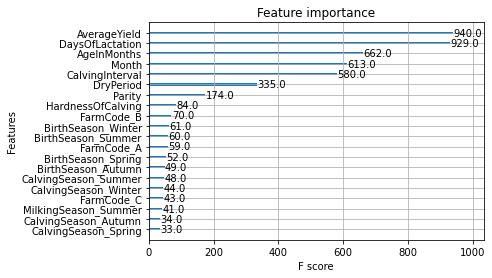

In [23]:
# Feature combination 3-1 (F3-1): F2 + columns generated from birth data set(fixed)
# Features: 'Month', 'FarmCode', 'Parity', 'DaysOfLactation', 'AgeInMonths', 'MilkYield'
#           'MilkingSeason', 'BirthSeason', 'CalvingSeason', 'CalvingInterval', 'IfFirstCalving', 'AverageYield',
#           'DryPeriod', 'HardnessOfCalving'

cols = ['Month', 'FarmCode', 'Parity', 'DaysOfLactation', 'AgeInMonths', 'MilkYield', 'MilkingSeason',
        'BirthSeason', 'CalvingSeason', 'CalvingInterval', 'IfFirstCalving', 'AverageYield', 'DryPeriod',
        'HardnessOfCalving']
df3_1 = df[df['Year'] != 2018]
df3_1 = pd.get_dummies(df3_1[cols]).copy()
X = df3_1.drop(['MilkYield'], axis=1)
y = df3_1['MilkYield']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

X_train = X_train.copy()
X_test = X_test.copy()
imputation(X_train)
imputation(X_test)

m3_svr1_acc, m3_rf1_acc, m3_xgb1_acc = test_algorithms(X_train, X_test, y_train, y_test)

# The performance of 2/3 models is better, so keep the birth data fixed

In [24]:
m3_svr_acc, m3_rf_acc, m3_xgb_acc = m3_svr1_acc, m3_rf1_acc, m3_xgb1_acc

In [25]:
df.describe()

,ID,Year,Month,CowNo,Parity,MilkYield,AgeInMonths,NumberOfBreeding,AverageYield,HardnessOfCalving,DryPeriod,DaysOfLactation,CalvingInterval,IfFirstCalving
count,33185.000000,33185.000000,33185.000000,3.318500e+04,33185.000000,33185.000000,33185.000000,33185.000000,20914.000000,22840.000000,28369.000000,33185.000000,33118.000000,33185.000000
mean,18548.120386,2015.759771,6.496248,2.559435e+07,1.956034,24.041242,47.528432,1.969504,25.084894,1.257093,30.405795,205.849330,239.069056,0.529125
std,10769.775824,1.704259,3.431113,4.090803e+07,1.234997,8.683938,19.294014,2.130174,5.530261,0.459601,43.027049,149.575596,247.429121,0.499159
min,1.000000,2013.000000,1.000000,5.261200e+04,1.000000,2.000000,0.000000,0.000000,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,9427.000000,2014.000000,4.000000,1.123375e+06,1.000000,18.000000,33.000000,0.000000,21.059259,1.000000,0.000000,89.000000,0.000000,0.000000
50%,18392.000000,2016.000000,6.000000,3.125318e+06,2.000000,23.500000,43.000000,1.000000,25.407407,1.000000,0.000000,182.000000,321.000000,1.000000
75%,27838.000000,2017.000000,10.000000,1.083798e+07,2.000000,30.000000,57.000000,3.000000,29.162500,1.000000,59.000000,287.000000,417.000000,1.000000
max,37517.000000,2018.000000,12.000000,9.918321e+07,11.000000,61.000000,160.000000,16.000000,41.000000,5.000000,659.000000,1789.000000,1234.000000,1.000000


15


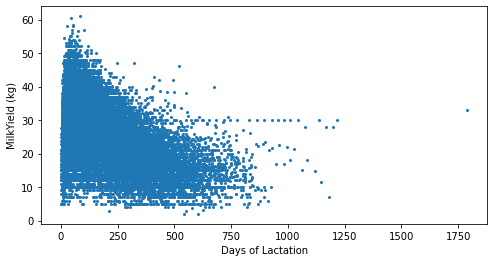

In [26]:
filt = df['DaysOfLactation']>1000
print(df[filt].index.nunique())

plt.figure(figsize=(8, 4))
plt.xlabel('Days of Lactation')
plt.ylabel('MilkYield (kg)')
plt.plot(df.DaysOfLactation, df.MilkYield, 'o', markersize=2)

31


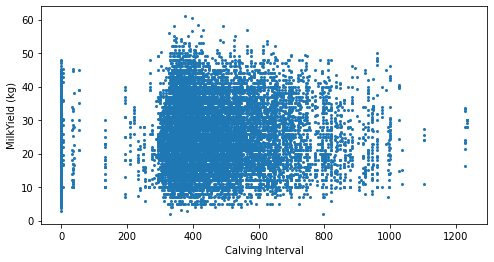

In [27]:
filt = df['CalvingInterval']>1100
print(df[filt].index.nunique())

plt.figure(figsize=(8, 4))
plt.xlabel('Calving Interval')
plt.ylabel('MilkYield (kg)')
plt.plot(df.CalvingInterval, df.MilkYield, 'o', markersize=2)

In [28]:
# Days of lactation should be around 305, so those too large must be errors.
# Calving Interval should be around 365 days
# Try fixing by method below:
# 1. If the calving interval > 22 months (660d), then add a calving date in between;
#    >33 (990d), add 2; >44 (1320d), add 3...
# 2. If the last calving date is far from 2019.12.31, add a calving date every year until 2019
# 3. For the dry period, since we suggested that these cow should calf almost every year 
#    in order to continuously produce milk, then the dry period must not be too long, either.
#    As a result, we inputed the missing or too large dry period with the average of the normal ones.
#    If there is no normal one, than inpute the common dry period: 60.

df1 = df.copy()
def AddCalving(cow):
    filt = (df1['CowNo'] == cow)
    list1 = list(set(df1.loc[filt, 'LatestCalvingDate']))
    list2 = list(set(df1.loc[filt, 'PreviousCalvingDate']))
    list3 = []
    for x in list2:
        if x not in list1 and str(x) != 'NaT':
            list3.append(x)
    caldates = list1 + list3
    caldates.sort()
    for i in range(len(caldates)-1):
        interval = (caldates[i+1] - caldates[i])/np.timedelta64(1, 'D')
        if 660 <= interval < 990:
            days = int(interval/2)
            caldates.append(caldates[i] + datetime.timedelta(days=days))
        elif 990 <= interval < 1320:
            days = int(interval/3)
            caldates.append(caldates[i] + datetime.timedelta(days=days))
            caldates.append(caldates[i] + datetime.timedelta(days=days*2))
        elif 1320 <= interval < 1650:
            days = int(interval/4)
            caldates.append(caldates[i] + datetime.timedelta(days=days))
            caldates.append(caldates[i] + datetime.timedelta(days=days*2)) 
            caldates.append(caldates[i] + datetime.timedelta(days=days*3))
    caldates.sort()
    x = caldates[-1]
    while (pd.to_datetime('2020-01-01') - x) > datetime.timedelta(days=365):
        caldates.append(caldates[-1] + datetime.timedelta(days=365))
        x = caldates[-1]
    caldates.sort()
    parlist = list(set(df1.loc[filt, 'Parity']))
    parlist.sort()
    start_par = parlist[0]
    pars = []
    pars.append(start_par)
    for i in range(len(caldates)-1):
        pars.append(start_par+i+1)
    if pars[0] == 1:
        if len(list3) == 0:
            for i in range(len(caldates)):
                if i == 0:
                    fix.fir(df1, cow, i+1, caldates[i], caldates[i+1])
                elif i == len(caldates)-1:
                    fix.last(df1, cow, i+1, caldates[i-1], caldates[i])
                else:
                    fix.mid(df1, cow, i+1, caldates[i-1], caldates[i], caldates[i+1])
        else:
            for i in range(len(caldates)):
                if i == 0:
                    fix.fir(df1, cow, i+1, caldates[i], caldates[i+1])
                elif i == len(caldates)-1:
                    fix.last(df1, cow, i, caldates[i-1], caldates[i])
                else:
                    fix.mid(df1, cow, i, caldates[i-1], caldates[i], caldate[i+1])
    else:
        par1 = pars[0]
        if len(list3) == 0:
            for i in range(len(caldates)):
                j = i + par1
                if i == 0:
                    fix.fir(df1, cow, j, caldates[i], caldates[i+1])
                elif i == len(caldates)-1:
                    fix.last(df1, cow, j, caldates[i-1], caldates[i])
                else:
                    fix.mid(df1, cow, j, caldates[i-1], caldates[i], caldates[i+1])
        else:
            for i in range(len(caldates)):
                j = par1 + i - 1
                if i == 0:
                    continue
                elif i == len(caldates)-1:
                    fix.last(df1, cow, j, caldates[i-1], caldates[i])
                else:
                    fix.mid(df1, cow, j, caldates[i-1], caldates[i], caldates[i+1])    
    drylist = []
    indexlist = df1.loc[filt].index
    for i in indexlist:
        if df1.loc[i, 'DryPeriod'] <100 and pd.isnull(df1.loc[i, 'DryPeriod'])==False:
            drylist.append(df1.loc[i, 'DryPeriod'])
    if len(drylist) > 0:
        dryaverage = int(sum(drylist)/len(drylist))
    else:
        dryaverage = 60
    for i in indexlist:
        if df1.loc[i,'Parity'] == 1:
            df1.loc[i,'DryPeriod'] = np.nan
        elif pd.isnull(df1.loc[i,'DryPeriod']) == True or df1.loc[i,'DryPeriod'] > 100:
            df1.loc[i,'DryPeriod'] = dryaverage

filt = (df1['DaysOfLactation'] > 600)
cowlist = list(set(df1.loc[filt, 'CowNo']))
print(cowlist)
for x in cowlist:
    AddCalving(x)

[3051521, 98122755, 1123334, 3051527, 3051528, 3051531, 3128845, 1123342, 3051535, 1123351, 3051548, 3051557, 10837547, 3051570, 3125308, 1123388, 94183486, 10837567, 94183489, 1123396, 3125322, 3125340, 3125343, 96121452, 3125357, 2122351, 96051829, 2122364, 96051844, 2122378, 3125387, 96051853, 2122383, 96185489, 2122387, 96123541, 3183614, 97126049, 96123553, 98186917, 98186928, 2127034, 2122431, 1181887, 1181889, 1051842, 94126787, 1181892, 99051719, 99051722, 99051723, 1051854, 1051855, 1051856, 2123481, 99051738, 2123486, 99051746, 99051751, 122602, 99051755, 122603, 99051757, 122614, 99051771, 122622, 122625, 99127554, 122630, 99127562, 122636, 87121678, 87121680, 122641, 122644, 99127572, 99127573, 122647, 99127575, 4181783, 97124122, 122656, 122658, 97051428, 99127591, 97051439, 98091824, 97124144, 98091826, 97051444, 93053241, 97051454, 97051461, 97124169, 97124171, 97051468, 97051469, 5184332, 98122576, 99127639, 3126109, 99127648, 99127649, 99127654, 99127658, 99127661, 991

In [29]:
# Add Dry Period again
df1 = df1.drop(columns=['DryPeriod'])
df1['DryPeriod'] = (df1['LatestCalvingDate'] - df1['PreviousDryDate']).astype('timedelta64[D]')

# Fix DaysOfLactation
df1 = df1.drop(columns=['DaysOfLactation'])
df1['DaysOfLactation'] = (df1['SampleDate'] - df1['LatestCalvingDate']).astype('timedelta64[D]')

# Fix columns: 'Calving Interval' & 'IfFirstCalving' & 'CalvingSeason'
df1 = df1.drop(columns=['CalvingInterval','IfFirstCalving','CalvingSeason'])
df1['CalvingInterval'] = (df1['LatestCalvingDate'] - df1['PreviousCalvingDate']).astype('timedelta64[D]')
df1['IfFirstCalving'] = np.nan
for i in df1.index:
    if df1.loc[i, 'Parity'] == 1:
        df1.loc[i, 'DryPeriod']=0
        df1.loc[i, 'CalvingInterval']=0
        df1.loc[i, 'IfFirstCalving']=0
    else:
        df1.loc[i, 'IfFirstCalving']=1
df1['CalvingSeason'] = ''
for i in df1.index:
    month = int(df1.loc[i, 'LatestCalvingDate'].month)
    if month in spring:
        df1.loc[i, 'CalvingSeason'] = 'Spring'
    elif month in summer:
        df1.loc[i, 'CalvingSeason'] = 'Summer'
    elif month in autumn:
        df1.loc[i, 'CalvingSeason'] = 'Autumn'
    elif month in winter:
        df1.loc[i, 'CalvingSeason'] = 'Winter'

X_train shape: (20824, 24) 

Model Performance

SVR:
Correlation Coefficient = 0.7017
RMSE = 6.2936
Accuracy= 74.98%

RF:
Correlation Coefficient = 0.7678
RMSE = 5.6396
Accuracy= 78.34%

XGB:
Correlation Coefficient = 0.7843
RMSE = 5.4656
Accuracy= 79.26%


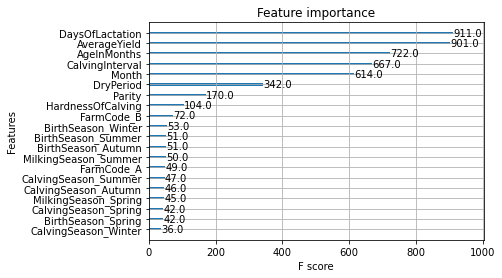

In [30]:
# Feature combination 3-2 (F3-2): F2(fixed) + columns generated from birth data set(fixed)
# Features: 'Month', 'FarmCode', 'Parity', 'DaysOfLactation', 'AgeInMonths', 'MilkYield'
#           'MilkingSeason', 'BirthSeason', 'CalvingSeason', 'CalvingInterval', 'IfFirstCalving', 'AverageYield',
#           'DryPeriod', 'HardnessOfCalving'

cols = ['Month', 'FarmCode', 'Parity', 'DaysOfLactation', 'AgeInMonths', 'MilkYield', 'MilkingSeason',
        'BirthSeason', 'CalvingSeason', 'CalvingInterval', 'IfFirstCalving', 'AverageYield', 'DryPeriod',
        'HardnessOfCalving']
df3_2 = df1[df1['Year'] != 2018]
df3_2 = pd.get_dummies(df3_2[cols]).copy()
X = df3_2.drop(['MilkYield'], axis=1)
y = df3_2['MilkYield']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

X_train = X_train.copy()
X_test = X_test.copy()
imputation(X_train)
imputation(X_test)

m3_svr2_acc, m3_rf2_acc, m3_xgb2_acc = test_algorithms(X_train, X_test, y_train, y_test)

# The performance of 2/3 models is worse, so keep F3-1

X_train shape: (20824, 24) 

Model Performance

SVR:
Correlation Coefficient = 0.7287
RMSE = 6.0483
Accuracy= 76.20%

RF:
Correlation Coefficient = 0.7724
RMSE = 5.5907
Accuracy= 78.78%

XGB:
Correlation Coefficient = 0.7869
RMSE = 5.4323
Accuracy= 79.57%


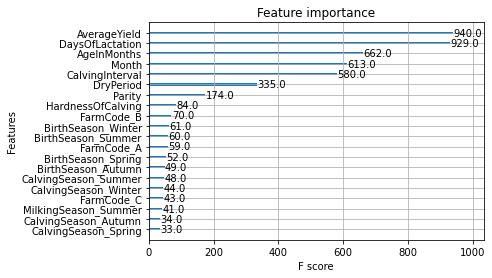

In [31]:
# Feature combination 3-3 (F3-3): F2(simply fixed) + columns generated from birth data set(fixed)
# Features: 'Month', 'FarmCode', 'Parity', 'DaysOfLactation', 'AgeInMonths', 'MilkYield'
#           'MilkingSeason', 'BirthSeason', 'CalvingSeason', 'CalvingInterval', 'IfFirstCalving', 'AverageYield',
#           'DryPeriod', 'HardnessOfCalving'
# For 'DaysOfLactation', fixing by deleting those >1000 in train data, and set as 1000 for those >1000 in test data
# For 'CalvingInterval', fixing by deleting those >1100 in train data, and set as 1100 for those >1100 in test data

cols = ['Month', 'FarmCode', 'Parity', 'DaysOfLactation', 'AgeInMonths', 'MilkYield', 'MilkingSeason',
        'BirthSeason', 'CalvingSeason', 'CalvingInterval', 'IfFirstCalving', 'AverageYield', 'DryPeriod',
        'HardnessOfCalving']
df3_3 = df[df['Year'] != 2018]
df3_3 = pd.get_dummies(df3_3[cols]).copy()
X = df3_3.drop(['MilkYield'], axis=1)
y = df3_3['MilkYield']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

X_train = X_train.copy()
X_test = X_test.copy()
for i in X_train.index:
    if X_train.loc[i, 'DaysOfLactation'] > 1000 or X_train.loc[i, 'CalvingInterval'] > 1100:
        X_train.drop(i)
for i in X_test.index:
    if X_test.loc[i, 'DaysOfLactation'] > 1000:
        X_test.loc[i, 'DaysOfLactation'] = 1000
    if X_test.loc[i, 'DaysOfLactation'] > 1100:
        X_test.loc[i, 'DaysOfLactation'] = 1100

imputation(X_train)
imputation(X_test)

m3_svr3_acc, m3_rf3_acc, m3_xgb3_acc = test_algorithms(X_train, X_test, y_train, y_test)

# The performance is a little bit better than F3-1, so keep F3-3

In [32]:
m3_svr_acc, m3_rf_acc, m3_xgb_acc = m3_svr3_acc, m3_rf3_acc, m3_xgb3_acc

In [33]:
# Section 4: Feature Generation (from spec data set)
spec.info()

# SituationCode describes the reason that caused the SituationType. If there were above 2 reasons,
# then there will be no SituationCode written. In this case, SituationType itself is filled.
# Report data starts at 2013, so we don't need the information that was too early.

spec1 = spec.copy()
spec1 = spec1.drop(['Remarks', 'RecordingDate'], axis=1)
spec1['SituationDate'] = pd.to_datetime(spec1['SituationDate'])
spec1 = spec1.drop(spec1[spec1.SituationDate < pd.to_datetime('2012-12-01')].index)
spec1['SituationType'] = spec1['SituationType'].replace({'n':'N', 'c':'C'})
for i in spec1.index:
    if pd.isnull(spec1.loc[i,'SituationCode']) == True:
        spec1.loc[i,'SituationCode'] = spec1.loc[i,'SituationType']
print(spec1.info())
print(spec1.SituationType.unique())
print(spec1.SituationCode.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4362 entries, 0 to 4361
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CowNo          4362 non-null   int64 
 1   SituationType  4362 non-null   object
 2   SituationCode  3749 non-null   object
 3   SituationDate  4362 non-null   object
 4   Remarks        1197 non-null   object
 5   RecordingDate  3104 non-null   object
 6   FarmCode       4362 non-null   object
dtypes: int64(1), object(6)
memory usage: 238.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2636 entries, 1497 to 4361
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CowNo          2636 non-null   int64         
 1   SituationType  2636 non-null   object        
 2   SituationCode  2636 non-null   object        
 3   SituationDate  2636 non-null   datetime64[ns]
 4   FarmCode       2636 non-null   obje

In [34]:
# Add 'SituationType', 'SituationCode'
# Assume that the time period that the cow is encountering the situation is from 1 day before the discovery
# to 1 month after

df['SituationType'] = np.nan
df['SituationCode'] = np.nan
for x in list(df['CowNo'].unique()):
    filt = (df['CowNo']==x)
    df_cow = df[filt]
    filt = (spec1['CowNo']==x)
    spec_cow = spec1[filt]
    for i in df_cow.index:
        for j in spec_cow.index:
            if spec1.loc[j,'SituationDate']-datetime.timedelta(days=1) <= df.loc[i,'SampleDate'] <= spec1.loc[j,'SituationDate']+datetime.timedelta(days=30):
                df.loc[i,'SituationType'] = spec1.loc[j,'SituationType']
                df.loc[i,'SituationCode'] = spec1.loc[j,'SituationCode']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33185 entries, 0 to 33184
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   33185 non-null  int64         
 1   Year                 33185 non-null  int64         
 2   Month                33185 non-null  int64         
 3   FarmCode             33185 non-null  object        
 4   CowNo                33185 non-null  int64         
 5   FatherSemenNo        32557 non-null  object        
 6   MotherNo             29940 non-null  object        
 7   BirthDate            33185 non-null  datetime64[ns]
 8   Parity               33185 non-null  int64         
 9   MilkYield            33185 non-null  float64       
 10  LatestCalvingDate    33185 non-null  datetime64[ns]
 11  SampleDate           33185 non-null  datetime64[ns]
 12  AgeInMonths          33185 non-null  int64         
 13  TestingDate          33185 non-

X_train shape: (20824, 46) 

Model Performance

SVR:
Correlation Coefficient = 0.7192
RMSE = 6.1363
Accuracy= 75.69%

RF:
Correlation Coefficient = 0.7721
RMSE = 5.5938
Accuracy= 78.79%

XGB:
Correlation Coefficient = 0.7853
RMSE = 5.4529
Accuracy= 79.48%


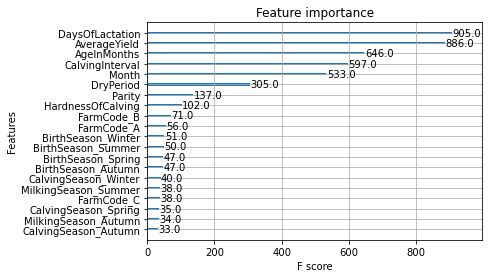

In [35]:
# Feature combination 4 (F4): F3(simply fixed) + columns generated from spec data set
# Features: 'Month', 'FarmCode', 'Parity', 'DaysOfLactation', 'AgeInMonths', 'MilkYield'
#           'MilkingSeason', 'BirthSeason', 'CalvingSeason', 'CalvingInterval', 'IfFirstCalving', 'AverageYield',
#           'DryPeriod', 'HardnessOfCalving',
#           'SituationType', 'SituationCode'

cols = ['Month', 'FarmCode', 'Parity', 'DaysOfLactation', 'AgeInMonths', 'MilkYield', 'MilkingSeason',
        'BirthSeason', 'CalvingSeason', 'CalvingInterval', 'IfFirstCalving', 'AverageYield', 'DryPeriod',
        'HardnessOfCalving', 'SituationType', 'SituationCode']
df4 = df[df['Year'] != 2018]
df4 = pd.get_dummies(df4[cols]).copy()
X = df4.drop(['MilkYield'], axis=1)
y = df4['MilkYield']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

X_train = X_train.copy()
X_test = X_test.copy()
for i in X_train.index:
    if X_train.loc[i, 'DaysOfLactation'] > 1000 or X_train.loc[i, 'CalvingInterval'] > 1100:
        X_train.drop(i)
for i in X_test.index:
    if X_test.loc[i, 'DaysOfLactation'] > 1000:
        X_test.loc[i, 'DaysOfLactation'] = 1000
    if X_test.loc[i, 'DaysOfLactation'] > 1100:
        X_test.loc[i, 'DaysOfLactation'] = 1100
imputation(X_train)
imputation(X_test)

m4_svr_acc, m4_rf_acc, m4_xgb_acc = test_algorithms(X_train, X_test, y_train, y_test)

In [36]:
# Section 5: Feature Generation (weather information)

# Add temperature and relative humidity data (information originally came from Taiwanese government)
# Fill missing values with mean of the month

# Define a function for getting information from weather datasets
def getTempandRH(stationcode, datayear, startmonth, endmonth):
    total_df = pd.DataFrame()
    for i in range(startmonth, endmonth+1):
        if i<10:
            j='0'+str(i)
        else:
            j=str(i)
        x = pd.read_csv('./Weather/'+stationcode+'-'+str(datayear)+'-'+j+'.csv')
        df = pd.DataFrame({'ObsDay':x['觀測時間(day)'],
                           'Temperature':x['氣溫(℃)'],
                           'RH':x['相對溼度(%)']})
        df = df.drop(index=[0])
        date_list = []
        for k in range(len(df.ObsDay)):
            day=str(df.loc[k+1, 'ObsDay'])
            date_list.append(str(datayear)+'/'+str(i)+'/'+day)
        df['Date'] = date_list
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.drop(['ObsDay'], axis=1)
        df = df.replace(['...','/','X'],np.nan)
        df['Temperature'] = df['Temperature'].astype('float')
        df['Temperature'] = df['Temperature'].fillna(df['Temperature'].mean()).round(1)
        df['RH'] = df['RH'].astype('float')
        df['RH'] = df['RH'].fillna(df['RH'].mean()).round()
        total_df = pd.concat([total_df, df])
    total_df.reset_index(drop=True, inplace=True)
    return total_df

# Generating dataframes for all weather data in 7 years (2013 ~ 2019), for total 3 farms (A:楊梅, B:福興, C:萬丹)
# Missing Temperature and RH from Jan. to Jul., 2013, for Farm A&C; and RH from Jan. to Feb., 2019 for Farm B
# Using linear regression with the information from 3 observation stations nearby to fill in the missing value
# Correlation test: correlation coefficient over 0.9 for both Temperature and RH 
# Evaluation test: MAE less than 0.5(℃) for temperature and 3(%) for RH
# Official observation station code: A:楊梅C0C660, nearby A: 平鎮C0C650 打鐵坑C0D480 大溪C0C630 /
# B:福興C0G770, nearby B: 鹿港C0G640 秀水C0G780 埔鹽C0G800 / C:萬丹C0R510, nearby C: 恆春467590 台東467660 台南467410


# Generate dataframe for all weather data in 7 years, for 3 farms
A_201301_07 = pd.read_csv('./Weather/A_201301_07.csv')
A_201308_12 = getTempandRH('C0C660',2013,8,12)
A_2014 = getTempandRH('C0C660',2014,1,12)
A_2015 = getTempandRH('C0C660',2015,1,12)
A_2016 = getTempandRH('C0C660',2016,1,12)
A_2017 = getTempandRH('C0C660',2017,1,12)
A_2018 = getTempandRH('C0C660',2018,1,12)
A_2019 = getTempandRH('C0C660',2019,1,12)

B_2013 = getTempandRH('C0G770',2013,1,12)
B_2014 = getTempandRH('C0G770',2014,1,12)
B_2015 = getTempandRH('C0G770',2015,1,12)
B_2016 = getTempandRH('C0G770',2016,1,12)
B_2017 = getTempandRH('C0G770',2017,1,12)
B_2018 = getTempandRH('C0G770',2018,1,12)
B_2019 = getTempandRH('C0G770',2019,1,12)
B_201901_02 = pd.read_csv('./Weather/B_201901_02.csv')

C_201301_07 = pd.read_csv('./Weather/C_201301_07.csv')
C_201308_12 = getTempandRH('C0R510',2013,8,12)
C_2014 = getTempandRH('C0R510',2014,1,12)
C_2015 = getTempandRH('C0R510',2015,1,12)
C_2016 = getTempandRH('C0R510',2016,1,12)
C_2017 = getTempandRH('C0R510',2017,1,12)
C_2018 = getTempandRH('C0R510',2018,1,12)
C_2019 = getTempandRH('C0R510',2019,1,12)

# Adding B_201901_02 (RH information) to B_2019
for i in range(len(B_201901_02['Date'])):
    B_2019.loc[i, 'RH'] = B_201901_02.loc[i, 'RH']

In [37]:
# Input the corresponding temperature and RH into main dataframe
A_weather = pd.concat([A_201301_07,A_201308_12,A_2014,A_2015,A_2016,A_2017,A_2018,A_2019])
B_weather = pd.concat([B_2013,B_2014,B_2015,B_2016,B_2017,B_2018,B_2019])
C_weather = pd.concat([C_201301_07,C_201308_12,C_2014,C_2015,C_2016,C_2017,C_2018,C_2019])
A_weather['FarmCode'] = 'A'
B_weather['FarmCode'] = 'B'
C_weather['FarmCode'] = 'C'
total_weather = pd.concat([A_weather, B_weather, C_weather])
total_weather['Date'] = pd.to_datetime(total_weather['Date'])

total_report = pd.merge(df, total_weather, left_on=['SampleDate', 'FarmCode'],
                        right_on=['Date', 'FarmCode'], how='left')
total_report.drop('Date', axis=1, inplace=True)


# Add column: 'THI'(Temperature humidity index, also known as HSI, Heat stress index) &'HeatStress'
# THI = (1.8 x T + 32) - (0.55 - 0.0055 x RH) x (1.8 x T - 26.8)
# 'HeatStress' 0: No heat stress, 1: Mild heat stress, 2: Moderate heat stress, 3: Severe heat stress
def THI(x):
    return (1.8 * x['Temperature'] + 32) - (0.55 - 0.0055 * x['RH']) * (1.8 * x['Temperature'] - 26.8)
total_report['THI'] = total_report.apply(lambda x: THI(x), axis =1)
total_report['THI'] = total_report['THI'].round(1)

def heatstress(x):
    if x['THI'] < 72:
        return int(0)
    elif 72 <= x['THI'] < 80:
        return int(1)
    elif 80 <= x['THI'] < 90:
        return int(2)
    elif x['THI'] >= 90:
        return(3)
total_report['HeatStress'] = total_report.apply(lambda x: heatstress(x), axis =1)

print(total_weather.info())
print(total_report.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7668 entries, 0 to 364
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Temperature  7668 non-null   float64       
 1   RH           7668 non-null   float64       
 2   Date         7668 non-null   datetime64[ns]
 3   FarmCode     7668 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 299.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 33185 entries, 0 to 33184
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   33185 non-null  int64         
 1   Year                 33185 non-null  int64         
 2   Month                33185 non-null  int64         
 3   FarmCode             33185 non-null  object        
 4   CowNo                33185 non-null  int64         
 5   FatherSeme

X_train shape: (20824, 50) 

Model Performance

SVR:
Correlation Coefficient = 0.7200
RMSE = 6.1298
Accuracy= 75.62%

RF:
Correlation Coefficient = 0.7646
RMSE = 5.6732
Accuracy= 78.38%

XGB:
Correlation Coefficient = 0.7764
RMSE = 5.5500
Accuracy= 78.98%


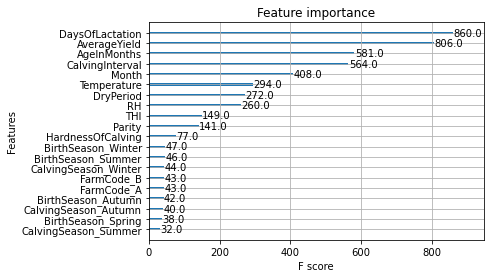

In [38]:
# Feature combination 5 (F5): F4(simply fixed) + columns of weather information
# Features: 'Month', 'FarmCode', 'Parity', 'DaysOfLactation', 'AgeInMonths', 'MilkYield'
#           'MilkingSeason', 'BirthSeason', 'CalvingSeason', 'CalvingInterval', 'IfFirstCalving', 'AverageYield',
#           'DryPeriod', 'HardnessOfCalving',
#           'SituationType', 'SituationCode',
#           'Temperature', 'RH', 'THI', 'HeatStress'

cols = ['Month', 'FarmCode', 'Parity', 'DaysOfLactation', 'AgeInMonths', 'MilkYield', 'MilkingSeason',
        'BirthSeason', 'CalvingSeason', 'CalvingInterval', 'IfFirstCalving', 'AverageYield', 'DryPeriod',
        'HardnessOfCalving', 'SituationType', 'SituationCode', 'Temperature', 'RH', 'THI', 'HeatStress']
df5 = total_report[total_report['Year'] != 2018]
df5 = pd.get_dummies(df5[cols]).copy()
X = df5.drop(['MilkYield'], axis=1)
y = df5['MilkYield']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

X_train = X_train.copy()
X_test = X_test.copy()
for i in X_train.index:
    if X_train.loc[i, 'DaysOfLactation'] > 1000 or X_train.loc[i, 'CalvingInterval'] > 1100:
        X_train.drop(i)
for i in X_test.index:
    if X_test.loc[i, 'DaysOfLactation'] > 1000:
        X_test.loc[i, 'DaysOfLactation'] = 1000
    if X_test.loc[i, 'DaysOfLactation'] > 1100:
        X_test.loc[i, 'DaysOfLactation'] = 1100
imputation(X_train)
imputation(X_test)

m5_svr_acc, m5_rf_acc, m5_xgb_acc = test_algorithms(X_train, X_test, y_train, y_test)

In [39]:
# Save the final dataframe
total_report.to_csv('./TotalData.csv', index=False)

In [40]:
# Section 6: Data Analysis

cols = ['Year', 'Month', 'FarmCode', 'Parity', 'DaysOfLactation', 'AgeInMonths', 'MilkYield', 'MilkingSeason',
        'BirthSeason', 'CalvingSeason', 'CalvingInterval', 'IfFirstCalving', 'AverageYield', 'DryPeriod',
        'HardnessOfCalving', 'SituationType', 'SituationCode', 'Temperature', 'RH', 'THI', 'HeatStress']
total_df = pd.get_dummies(total_report[cols]).copy()

#Correlation test
total_corr = total_df.corr()
high_corr = total_corr[abs(total_corr['MilkYield'])>=0.3]
high_corr['MilkYield']

DaysOfLactation   -0.467823
MilkYield          1.000000
AverageYield       0.368449
FarmCode_B         0.316814
FarmCode_C        -0.362792
Name: MilkYield, dtype: float64

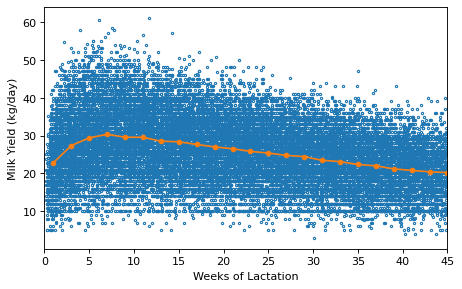

In [71]:
# MilkYield vs DaysOfLactation

wood = total_report[total_report['DaysOfLactation']<315].copy()
wood['WeeksOfLactation'] = [x/7 for x in wood['DaysOfLactation']]
wood['group'] = [int(x/14)*2+1 for x in wood['DaysOfLactation']]
plt.figure(figsize=(6.5,4), dpi=80)
plt.xlim(0,45)
plt.xlabel("Weeks of Lactation")
plt.ylabel("Milk Yield (kg/day)")
plt.plot(wood.WeeksOfLactation,wood.MilkYield,'o', markerfacecolor='none',markersize=2)
plt.plot(wood.groupby('group')['MilkYield'].mean(), marker='o', ms=4)
plt.show()

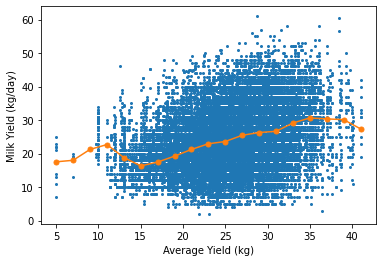

In [72]:
# MilkYield vs AverageYield

ay = total_report.dropna(subset=['AverageYield']).copy()
ay['group'] = [int(x/2)*2+1 for x in ay['AverageYield']]
plt.figure(figsize=(6, 4))
plt.xlabel('Average Yield (kg)')
plt.ylabel('Milk Yield (kg/day)')
plt.plot(ay.AverageYield, ay.MilkYield, 'o', markersize=2)
plt.plot(ay.groupby('group')['MilkYield'].mean(), marker='o', ms=5)
plt.show()

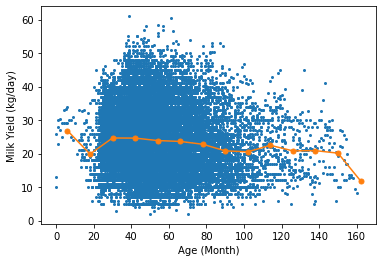

In [73]:
# MilkYield vs AgeInMonths

aim = total_report.dropna(subset=['AgeInMonths']).copy()
aim['group'] = [int(x/12)*12+6 for x in aim['AgeInMonths']]
plt.figure(figsize=(6, 4))
plt.xlabel('Age (Month)')
plt.ylabel('Milk Yield (kg/day)')
plt.plot(aim.AgeInMonths, aim.MilkYield, 'o', markersize=2)
plt.plot(aim.groupby('group')['MilkYield'].mean(), marker='o', ms=5)
plt.show()

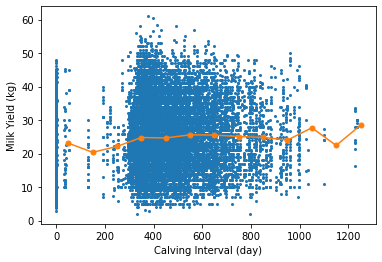

In [74]:
# MilkYield vs CalvingInterval

ci = total_report.dropna(subset=['CalvingInterval']).copy()
ci['group'] = [int(x/100)*100+50 for x in ci['CalvingInterval']]
plt.figure(figsize=(6, 4))
plt.xlabel('Calving Interval (day)')
plt.ylabel('Milk Yield (kg)')
plt.plot(ci.CalvingInterval, ci.MilkYield, 'o', markersize=2)
plt.plot(ci.groupby('group')['MilkYield'].mean(), marker='o', ms=5)
plt.show()

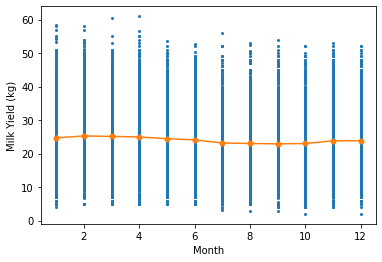

In [75]:
# MilkYield vs Month

plt.figure(figsize=(6, 4))
plt.xlabel('Month')
plt.ylabel('Milk Yield (kg)')
plt.plot(total_report.Month, total_report.MilkYield, 'o', markersize=2)
plt.plot(total_report.groupby('Month')['MilkYield'].mean(), marker='o', ms=5)
plt.show()

In [46]:
# Section 7: Machine Learning Models

# Define a function for data processing
def data_processing(data, cols):
    total_df = pd.get_dummies(data[cols]).copy()
    seen_df = total_df[total_df['Year'] != 2018]
    seen_df = seen_df.drop(['Year'], axis=1)
    X = seen_df.drop(['MilkYield'], axis=1)
    y = seen_df['MilkYield']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
    X_train = X_train.copy()
    X_test = X_test.copy()

    unseen_df = total_df[total_df['Year'] == 2018]
    unseen_df = unseen_df.drop(['Year'], axis=1).copy()

    for i in X_train.index:
        if X_train.loc[i, 'DaysOfLactation'] > 1000 or X_train.loc[i, 'CalvingInterval'] > 1100:
            X_train.drop(i)
    for i in X_test.index:
        if X_test.loc[i, 'DaysOfLactation'] > 1000:
            X_test.loc[i, 'DaysOfLactation'] = 1000
        if X_test.loc[i, 'CalvingInterval'] > 1100:
            X_test.loc[i, 'CalvingInterval'] = 1100
    for i in unseen_df.index:
        if unseen_df.loc[i, 'DaysOfLactation'] > 1000:
            unseen_df.loc[i, 'DaysOfLactation'] = 1000
        if unseen_df.loc[i, 'CalvingInterval'] > 1100:
            unseen_df.loc[i, 'CalvingInterval'] = 1100
    imputation(X_train)
    imputation(X_test)
    imputation(unseen_df)
    return X_train, X_test, y_train, y_test, unseen_df

cols = ['Year', 'Month', 'FarmCode', 'Parity', 'DaysOfLactation', 'AgeInMonths', 'MilkYield', 'MilkingSeason',
        'BirthSeason', 'CalvingSeason', 'CalvingInterval', 'IfFirstCalving', 'AverageYield', 'DryPeriod',
        'HardnessOfCalving', 'SituationType', 'SituationCode', 'Temperature', 'RH', 'THI', 'HeatStress']
X_train, X_test, y_train, y_test, unseen_df = data_processing(total_report, cols)

In [47]:
# Define a function for GridSearchCV (to tune the hyperparameters)
def Grid(model, grid_params, train_features, train_labels, cv=5):
    grid = GridSearchCV(model, grid_params, scoring='neg_mean_absolute_percentage_error', cv=cv, verbose=1, n_jobs=-1, refit=True)
    grid.fit(train_features, train_labels)
    print('Best parameters:', grid.best_params_)
    print('Best score:', grid.best_score_, '\n')
    return grid

In [ ]:
sc = StandardScaler()
scaledX_train = sc.fit_transform(X_train)
scaledX_train = pd.DataFrame(data = scaledX_train, columns = X_train.columns)
scaledX_test = sc.fit_transform(X_test)
scaledX_test = pd.DataFrame(data = scaledX_test, columns = X_test.columns)

In [48]:
# Simply tune the hyperparameters of with GridSearchCV

# SVR
print('SVR:')
model = SVR()
grid_params = {'kernel':['linear','poly','rbf','sigmoid']}
grid = Grid(model, grid_params, scaledX_train, y_train, cv=3)
model_accuracy = evaluate(grid, scaledX_test, y_test)

SVR:
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters: {'kernel': 'rbf'}
Best score: -0.24365763621238856 

Correlation Coefficient = 0.7200
RMSE = 6.1299
Accuracy= 75.62%


In [49]:
model = SVR()
grid_params = {'kernel':['rbf'],
               'gamma':['scale','auto',1e-3,1e-2,0.1,1],
               'C': [0.1,1,10,100]}
grid = Grid(model, grid_params, scaledX_train, y_train)
model_accuracy = evaluate(grid, scaledX_test, y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: -0.22741155900877116 

Correlation Coefficient = 0.7441
RMSE = 5.9378
Accuracy= 77.18%


In [ ]:
params = {'C': 100,
          'gamma': 'scale',
          'kernel': 'rbf'}
tuned_svr = SVR(**params)
tuned_svr.fit(scaledX_train, y_train)
tuned_svr_acc = model_accuracy(tuned_svr, scaledX_test, y_test)

In [52]:
# Random Forest Regression parameter tuning

# Use RandomizedSearchCV to test 100 different combination of the hyperparameters,
# in order to decide the starting point that is highly possible to be close to the best hyperparameter combinaion.
start = datetime.datetime.now()

#
n_estimators = [int(x) for x in range(200, 2001, 200)]
max_features = [1.0, 'sqrt']
max_depth = [int(x) for x in range(10, 101, 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# There are 10 * 2 * 11 * 3 * 3 * 2 = 3960 sets in total
# Use the random grid to search random 400 sets for best hyperparameters
RF = RandomForestRegressor(random_state=42)
RF_random = RandomizedSearchCV(estimator = RF, param_distributions = random_grid, n_iter = 400, cv = 3, verbose=2, scoring='neg_root_mean_squared_error', random_state=42, n_jobs = -1)
RF_random.fit(X_train, y_train)
print('\n', RF_random.best_params_)

RF_random_accuracy = evaluate(RF_random, X_test, y_test)
#

end = datetime.datetime.now()
print('\nExecution time:', (end - start))

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': [1.0, 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 400 candidates, totalling 1200 fits
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=  23.5s
[CV] END bootstrap=True, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 2.3min
[CV] END bootstrap=False, max_depth=90, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time= 4.0min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  15.3s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total t

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  18.1s[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=  24.2s
[CV] END bootstrap=True, max_depth=50, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  24.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=  30.3s
[CV] END bootstrap=True, max_depth=30, max_features=1.0, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time= 2.8min
[CV] END bootstrap=False, max_depth=90, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time= 4.3min
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  40.6s
[CV] END bootstrap=True, max_depth=None,

[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time= 1.1min[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=  24.4s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=  21.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=  30.8s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=  35.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  16.7s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  26.1s
[CV] END bootstrap=False, max_depth=80

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time= 1.1min[CV] END bootstrap=True, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 2.3min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  24.5s
[CV] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 4.0min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  16.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=  31.1s
[CV] END bootstrap=False, max_depth=70, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time= 2.9min
[CV] END bootstrap=False, max_dep

[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time= 1.2min[CV] END bootstrap=True, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 2.3min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  24.9s
[CV] END bootstrap=False, max_depth=90, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time= 4.1min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  15.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=  30.9s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=  30.7s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  13.7s[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=  24.3s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=  21.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=  20.8s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=  35.7s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  17.3s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  19.1s
[CV] END bootstrap=False, max_depth=80,

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time=  44.2s[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=  23.7s
[CV] END bootstrap=True, max_depth=50, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  24.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=  30.9s
[CV] END bootstrap=True, max_depth=30, max_features=1.0, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time= 2.8min
[CV] END bootstrap=False, max_depth=90, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time= 4.1min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=  32.3s
[CV] END bootstrap=True, max_depth=None,

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=  32.6s[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=  23.9s
[CV] END bootstrap=True, max_depth=50, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  24.3s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=  33.1s
[CV] END bootstrap=True, max_depth=30, max_features=1.0, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time= 2.8min
[CV] END bootstrap=False, max_depth=90, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time= 4.2min
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  40.9s
[CV] END bootstrap=True, max_depth=None, m

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  27.3s
 {'n_estimators': 1400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': 20, 'bootstrap': True}
Correlation Coefficient = 0.7732
RMSE = 5.5866
Accuracy= 78.64%

Execution time: 3:06:40.511935


In [58]:
# Tune the hyperparameters based on the best result from random search with GridSearchCV
start = datetime.datetime.now()

#
model = RandomForestRegressor(random_state=42)
grid_params = {'n_estimators': [1300, 1400, 1500],
               'max_features': [1.0],
               'max_depth': [10, 20, 30],
               'min_samples_split': [4, 5, 6],
               'min_samples_leaf': [1, 2],
               'bootstrap': [True]}
grid = Grid(model, grid_params, X_train, y_train)
model_accuracy = evaluate(grid, X_test, y_test)
#

end = datetime.datetime.now()
print('\nExecution time:', (end - start))

# The result is worse than RF_random, perhaps because of overfitting, so keep RF_random

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1400}
Best score: -0.2184394179654518 

Correlation Coefficient = 0.7730
RMSE = 5.5880
Accuracy= 78.64%

Execution time: 2:27:37.577575


In [60]:
params =  {'n_estimators': 1400,
           'min_samples_split': 5,
           'min_samples_leaf': 1,
           'max_features': 1.0,
           'max_depth': 20,
           'bootstrap': True}
tuned_rf = RandomForestRegressor(**params, random_state=42)
tuned_rf.fit(X_train, y_train)
tuned_rf_acc = evaluate(tuned_rf, X_test, y_test)

Correlation Coefficient = 0.7732
RMSE = 5.5866
Accuracy= 78.64%


In [54]:
# XGBoost parameter tuning

# Use RandomizedSearchCV to test 100 different combination of the hyperparameters,
# in order to decide the starting point that is highly possible to be close to the best hyperparameter combinaion.
start = datetime.datetime.now()

#
learning_rate = [0.1, 0.2, 0.3]
n_estimators = [int(x) for x in range(200, 1001, 200)]
max_depth = [int(x) for x in range(3, 10, 2)]
min_child_weight = [int(x) for x in range(1, 6, 2)]
subsample = [x/10.0 for x in range(6, 11, 2)]
colsample_bytree = [x/10.0 for x in range(6, 11, 2)]
gamma = [x/10.0 for x in range(0, 5, 2)]

random_grid = {'learning_rate': learning_rate,
               'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_child_weight': min_child_weight,
               'subsample': subsample,
               'colsample_bytree': colsample_bytree,
               'gamma': gamma}
print(random_grid)

# There are 3 * 5 * 4 * 3 * 3 * 3 * 3 = 4860 settings in total
# Use the random grid to search for best hyperparameters
XGB = XGBRegressor(seed=42)
XGB_random = RandomizedSearchCV(estimator = XGB, param_distributions = random_grid, n_iter = 500, cv = 3, verbose=2, random_state=42, n_jobs = -1)
XGB_random.fit(X_train, y_train)
print('\n', XGB_random.best_params_)

XGB_random_accuracy = evaluate(XGB_random, X_test, y_test)
#

end = datetime.datetime.now()
print('\nExecution time:', (end - start))

{'learning_rate': [0.1, 0.2, 0.3], 'n_estimators': [200, 400, 600, 800, 1000], 'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'gamma': [0.0, 0.2, 0.4]}
Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=800, subsample=1.0; total time=  43.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=800, subsample=1.0; total time= 2.0min
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=  10.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=  11.0s
[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=600, subsample=

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=600, subsample=1.0; total time=  55.9s[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=600, subsample=0.6; total time= 1.8min
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.8; total time=  11.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=200, subsample=1.0; total time=  33.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=400, subsample=1.0; total time= 1.6min
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=600, subsample=0.8; total time= 1.5min
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=200, subsample=0.6

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=400, subsample=1.0; total time=  33.4s[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=800, subsample=1.0; total time=  44.1s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=400, subsample=0.8; total time= 1.0min
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.8; total time=  11.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=200, subsample=1.0; total time=  33.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=400, subsample=1.0; total time= 1.6min
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=800, subsample=1.0

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=400, subsample=1.0; total time=  53.9s[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=600, subsample=0.6; total time= 1.8min
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=200, subsample=1.0; total time=  35.5s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=1000, subsample=0.6; total time=  51.9s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.8; total time=  38.0s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=400, subsample=0.8; total time=  54.6s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1, n_estimators=400, subsample=0.

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=400, subsample=0.6; total time=  20.6s[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=800, subsample=1.0; total time= 2.1min
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=400, subsample=0.6; total time=  21.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=400, subsample=1.0; total time= 1.6min
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=800, subsample=1.0; total time= 1.7min
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=200, subsample=0.6; total time=  44.3s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=1000, subsample=0.

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=600, subsample=1.0; total time=  55.8s[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=800, subsample=1.0; total time=  44.0s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=400, subsample=0.8; total time= 1.0min
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=400, subsample=0.8; total time= 1.1min
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=  11.1s
[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=600, subsample=1.0; total time=  34.5s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=400, subsample=0.8

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=400, subsample=1.0; total time=  58.4s[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=600, subsample=0.6; total time= 1.8min
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.8; total time=  11.5s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=400, subsample=0.6; total time=  21.6s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=1000, subsample=0.6; total time=  51.5s
[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=600, subsample=1.0; total time=  34.1s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=400, subsample=0.

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=9, min_child_weight=3, n_estimators=200, subsample=0.8; total time=  48.9s[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=800, subsample=1.0; total time= 2.0min
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=400, subsample=0.6; total time=  21.9s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=1000, subsample=0.6; total time=  51.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.8; total time=  38.4s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=800, subsample=1.0; total time= 1.7min
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1, n_estimators=400, subsample=0.

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=800, subsample=0.8; total time= 1.8min
[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.3, max_depth=9, min_child_weight=5, n_estimators=1000, subsample=0.6; total time= 4.1min
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=400, subsample=0.8; total time=  41.8s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=800, subsample=1.0; total time=  49.2s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=400, subsample=0.6; total time=  42.6s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=400, subsample=1.0; total time=  20.4s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=600, subsample=0

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=400, subsample=0.8; total time=  38.4s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=800, subsample=0.8; total time= 1.3min
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1, n_estimators=800, subsample=1.0; total time= 2.7min
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=9, min_child_weight=1, n_estimators=1000, subsample=1.0; total time= 3.2min
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.3, max_depth=9, min_child_weight=1, n_estimators=400, subsample=1.0; total time= 1.4min
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=600, subsample=0.6; total time=  33.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=200, subsample=0

[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=1000, subsample=0.6; total time= 2.2min
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=400, subsample=0.6; total time=  20.3s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=400, subsample=0.8; total time=  22.0s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=800, subsample=0.8; total time= 1.3min
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=600, subsample=0.8; total time=  54.6s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=600, subsample=0.8; total time= 1.7min
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=800, subsample=1

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=400, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=600, subsample=0.8; total time=  33.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1, n_estimators=800, subsample=1.0; total time= 2.8min
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=9, min_child_weight=1, n_estimators=1000, subsample=1.0; total time= 3.2min
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=400, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=1000, subsample=1.0; total time= 2.8min
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=600, subsample=

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=1000, subsample=0.6; total time= 1.6min
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=800, subsample=0.8; total time= 1.8min
[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.3, max_depth=9, min_child_weight=5, n_estimators=1000, subsample=0.6; total time= 4.7min
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=400, subsample=1.0; total time=  20.6s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=400, subsample=1.0; total time=  19.7s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=600, subsample=0.8; total time=  55.5s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=200, subsample=

[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=600, subsample=1.0; total time=  36.3s
[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=1000, subsample=0.8; total time= 3.0min
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=800, subsample=1.0; total time=  46.7s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=600, subsample=0.8; total time=  37.3s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=600, subsample=0.6; total time= 2.6min
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=600, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=600, subsample=0

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=800, subsample=0.6; total time= 1.9min
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=1000, subsample=0.6; total time= 2.4min
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=1000, subsample=1.0; total time= 2.7min
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=800, subsample=1.0; total time=  48.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=600, subsample=0.8; total time=  36.4s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=600, subsample=0.6; total time= 2.6min
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=400, subsample=

[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=200, subsample=1.0; total time=  26.7s
[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=400, subsample=0.8; total time=  21.3s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=1000, subsample=0.6; total time= 2.4min
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=1000, subsample=1.0; total time= 2.6min
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=400, subsample=0.8; total time=  45.8s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=600, subsample=0.6; total time=  38.0s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=400, subsample=

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.3, max_depth=9, min_child_weight=1, n_estimators=200, subsample=1.0; total time=  45.0s
 {'subsample': 1.0, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.6}
Correlation Coefficient = 0.7991
RMSE = 5.2937
Accuracy= 80.21%

Execution time: 4:10:03.985758


In [59]:
# Tune the hyperparameters based on the best result from random search
# First, tune max_depth, min_child_weight, subsample, colsample_bytree, and gamma with GridSearchCV
start = datetime.datetime.now()

#
model = XGBRegressor(seed=42)
grid_params = {'learning_rate': [0.1],
               'n_estimators': [1000],
               'max_depth': [4, 5, 6],
               'min_child_weight': [1, 2, 3],
               'subsample': [0.9, 0.95, 1.0],
               'colsample_bytree': [0.5, 0.6, 0.7],
               'gamma': [0.1, 0.2, 0.3]}
grid = Grid(model, grid_params, X_train, y_train)
model_accuracy = evaluate(grid, X_test, y_test)
#

end = datetime.datetime.now()
print('\nExecution time:', (end - start))

# The result is worse than XGB_random, perhaps because of overfitting, so keep XGB_random

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 0.95}
Best score: -0.20052478474373214 

Correlation Coefficient = 0.7929
RMSE = 5.3678
Accuracy= 80.05%

Execution time: 4:12:17.843730


Correlation Coefficient = 0.7991
RMSE = 5.2937
Accuracy= 80.21%


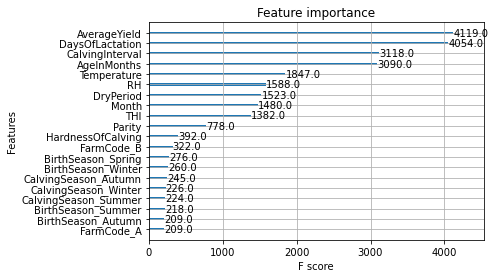

In [69]:
params = {'subsample': 1.0,
          'n_estimators': 1000,
          'min_child_weight': 1,
          'max_depth': 5,
          'learning_rate': 0.1,
          'gamma': 0.2,
          'colsample_bytree': 0.6}
tuned_xgb = XGBRegressor(**params, seed=42)
tuned_xgb.fit(X_train, y_train)
tuned_xgb_acc = evaluate(tuned_xgb, X_test, y_test)
plot_importance(tuned_xgb, max_num_features=20)
plt.savefig('/Users/guanguan/Desktop/Comprehensive_Report/Taiwanese_Data/Feature_Importance.png')
plt.show()

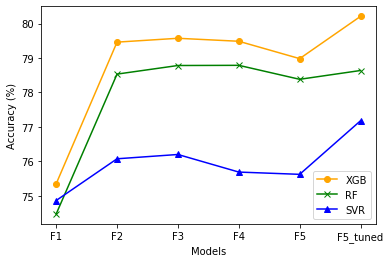

In [63]:
# Plot accuracy curves (F1~F5 + F5_tuned)
acc_dict = {'Models':['F1','F2','F3','F4','F5','F5_tuned'],
            'SVR':[m1_svr_acc,m2_svr_acc,m3_svr_acc,m4_svr_acc,m5_svr_acc,tuned_svr_acc],
            'RF':[m1_rf_acc,m2_rf_acc,m3_rf_acc,m4_rf_acc,m5_rf_acc,tuned_rf_acc],
            'XGB':[m1_xgb_acc,m2_xgb_acc,m3_xgb_acc,m4_xgb_acc,m5_xgb_acc,tuned_xgb_acc]}
acc_df = pd.DataFrame(data = acc_dict)
acc_df = acc_df.set_index('Models').rename_axis(None)

plt.figure(figsize=(6, 4))
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.plot(acc_df.XGB, color = 'orange', label='XGB', marker='o')
plt.plot(acc_df.RF, color = 'green', label='RF', marker='x')
plt.plot(acc_df.SVR, color = 'blue', label='SVR', marker='^')
plt.legend(loc='lower right')
plt.savefig('/Users/guanguan/Desktop/Comprehensive_Report/Taiwanese_Data/Accuracies(F1-F5 & F5_tuned).png')
plt.show()

Prediction performance on unseen data (in 2018)

Final SVR:
Correlation Coefficient = 0.6898
RMSE = 6.3057
Accuracy= 74.68%

Final RF:
Correlation Coefficient = 0.7194
RMSE = 5.8317
Accuracy= 75.95%

Final XGB:
Correlation Coefficient = 0.7208
RMSE = 5.8607
Accuracy= 76.33%


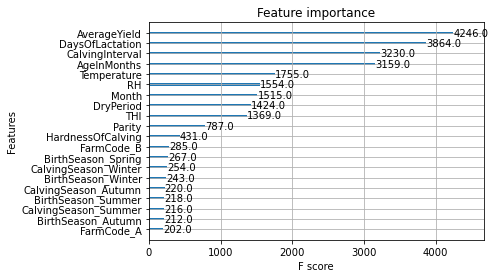

In [70]:
# Predict data in 2018
total_df = pd.get_dummies(total_report[cols]).copy()
seen_df = total_df[total_df['Year'] != 2018]
seen_df = seen_df.drop(['Year'], axis=1)
X = seen_df.drop(['MilkYield'], axis=1)
y = seen_df['MilkYield']
unseen_df = total_df[total_df['Year'] == 2018]
unseen_df = unseen_df.drop(['Year'], axis=1).copy()
unseen_X = unseen_df.drop(['MilkYield'], axis=1)
unseen_y = unseen_df['MilkYield']

for i in X.index:
    if X.loc[i, 'DaysOfLactation'] > 1000 or X.loc[i, 'CalvingInterval'] > 1100:
        X.drop(i)
for i in unseen_X.index:
    if unseen_X.loc[i, 'DaysOfLactation'] > 1000:
        unseen_X.loc[i, 'DaysOfLactation'] = 1000
    if unseen_X.loc[i, 'CalvingInterval'] > 1100:
        unseen_X.loc[i, 'CalvingInterval'] = 1100

imputation(X)
imputation(unseen_X)

sc = StandardScaler()
scaled_X = sc.fit_transform(X)
scaled_X = pd.DataFrame(data = scaled_X, columns = X.columns)
scaled_unseen_X = sc.fit_transform(unseen_X)
scaled_unseen_X = pd.DataFrame(data = scaled_unseen_X, columns = unseen_X.columns)

print("Prediction performance on unseen data (in 2018)\n")
# Fianl SVR
print("Final SVR:")
params = {'C': 100,
          'gamma': 'scale',
          'kernel': 'rbf'}
final_svr = SVR(**params)
final_svr.fit(scaled_X, y)
final_svr_performance = evaluate(final_svr, scaled_unseen_X, unseen_y)

# Final RF
print("\nFinal RF:")
params =  {'n_estimators': 1400,
           'min_samples_split': 5,
           'min_samples_leaf': 1,
           'max_features': 1.0,
           'max_depth': 20,
           'bootstrap': True}
final_rf = RandomForestRegressor(**params, random_state=42)
final_rf.fit(X, y)
final_rf_performance = evaluate(final_rf, unseen_X, unseen_y)

# Final XGB
print("\nFinal XGB:")
params = {'subsample': 1.0,
          'n_estimators': 1000,
          'min_child_weight': 1,
          'max_depth': 5,
          'learning_rate': 0.1,
          'gamma': 0.2,
          'colsample_bytree': 0.6}
final_xgb = XGBRegressor(**params, seed=42)
final_xgb.fit(X, y)
final_xgb_performance = evaluate(final_xgb, unseen_X, unseen_y)
plot_importance(final_xgb, max_num_features=20)
plt.show()